In [88]:
import numpy as np
import tifffile as tf
import ntpath
import os
import matplotlib.pyplot as plt
import sys
import time
from paq2py import *
from utils import *
import seaborn as sns
%matplotlib inline

In [2]:
paq_path = r'C:\Users\Curtis-E-Bear\Desktop\J031_4\2019-02-28_J031_packIO_004.paq'
naparm_path = r'C:\Users\Curtis-E-Bear\Desktop\J031_4\2019-02-28_J031_NAPARM_003'
xml_path = next(os.path.join(naparm_path, file) for file in os.listdir(naparm_path) if file.endswith('.xml'))
gpl_path = next(os.path.join(naparm_path, file) for file in os.listdir(naparm_path) if file.endswith('.gpl'))

In [3]:
paq = paq_read(paq_path)
for k,v in paq.items():
    print(k) 

data
chan_names
hw_chans
units
rate


In [4]:
paq['chan_names']

['x_galvo_uncaging',
 'packio2slm',
 'slm2packio',
 'packio2markpoints',
 'markpoints2packio',
 'frame_clock']

In [5]:
paq['rate']

20000

In [6]:
m2p_idx = paq['chan_names'].index('markpoints2packio')
m2p = paq['data'][m2p_idx, :]
stim_samples = np.where(np.diff(m2p) > 4)[0]

(400000, 410000)

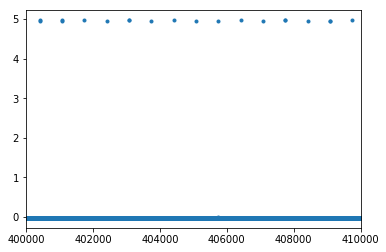

In [167]:
clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]
clock_samples =  np.where(np.diff(clock_voltage) > 2)[0]

plt.plot(clock_voltage, '.')
plt.xlim([400000,410000])

In [174]:
clock_samples =  np.where(np.diff(clock_voltage) > 0.01)[0]
differ = np.diff(clock_samples)

c = np.where((differ > 100) & (differ < 1000))[0]

#plt.plot(differ[c])
len(c)

1954

In [123]:
def debounce(arr, window):
    '''
    function to debounce arrays based on the numeric values of arr1, used for example when the trial outcome is erroneously printed twice
    removes subsequent elements of an array that occur within a time window to the previous element
    '''
    for i,a in enumerate(arr):
        # finish debouncing if reach the final element
        if i == len(arr) - 1:
            return arr

        else:
            diff = arr[i+1] - arr[i]
            if diff <= window:
                del arr[i+1]
                # recursively call debounce function
                debounce(arr,window)

In [136]:
d = debounce(list(clock_samples), 666.6666666666666)
len(clock_samples)

1962

In [127]:
(1/30) * 20000

666.6666666666666

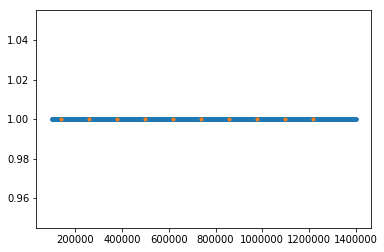

In [8]:
plt.plot(clock_samples, np.ones(len(clock_samples)), '.')
plt.plot(stim_samples, np.ones(len(stim_samples)), '.')
#plt.xlim([279000, 280000])

In [9]:
markpoints = ParseMarkpoints(xml_path=xml_path, gpl_path=gpl_path)
assert len(stim_samples) == int(markpoints.iterations)

In [10]:
# assume all group durations the same
duration = float(markpoints.durations[0]) #ms
duration_samples = (duration / 1000) * paq['rate']
duration_samples

200.0

In [89]:
#use this to remove frames during stim based on paq
to_remove = []

for stim in stim_samples:

    #the sample time of the frame immediately preceeding stim
    stim_start_frame = next(clock_samples[i-1] for i,sample in enumerate(clock_samples) if sample - stim > 0)

    # frame indexes that fall during the stim
    in_stim = np.where((clock_samples >= stim_start_frame) & (clock_samples <= stim + duration_samples))[0]

    [to_remove.append(f) for f in in_stim]


0.004613399505615234

In [87]:
stim_start_frames = []

for stim in stim_samples:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(clock_samples) if sample - stim > 0)
    
    stim_start_frames.append(stim_start_frame)
    
assert len(stim_start_frames) == int(markpoints.iterations)

In [152]:
remove_arr = np.load(r"C:\Users\Curtis-E-Bear\Desktop\J031_4\remove\suite2p\plane0\F.npy")
remove_arr.shape

(240, 1942)

In [154]:
noremove_arr = np.load(r"C:\Users\Curtis-E-Bear\Desktop\J031_4\noremove\suite2p\plane0\F.npy")
noremove_arr.shape

(195, 1942)

In [155]:
len(clock_samples)

1962

In [105]:
def threshold_detect(signal, threshold):
    thresh_signal = signal > threshold
    thresh_signal[1:][thresh_signal[:-1] & thresh_signal[1:]] = False
    times = np.where(thresh_signal)
    return times[0]

In [107]:
# # get frame times
# frame_trace = clock_voltage
# rate = paq['rate']
# frame_times = threshold_detect(frame_trace, 1).astype(np.float) / rate
# frame_times = frame_times[(frame_times > sync_start) & (frame_times < sync_stop)]
# frame_times = frame_times[0:num_frames]

In [109]:
len(frame_times)

1955